# 📘 Garbage Classification: Advanced Transfer Learning Pipeline 🚀

This notebook presents a complete, production-ready pipeline for automatically classifying six common household waste categories: **cardboard**, **glass**, **metal**, **paper**, **plastic**, and **trash**, leveraging advanced **transfer learning** methods.

In this project, I have:

- Loaded, preprocessed, and augmented image data effectively.
- Tackled class imbalance by calculating and applying data-driven class weights.
- Trained and benchmarked multiple high-performance CNN backbones: **EfficientNetV2S**, **EfficientNetV2M**, **EfficientNetV2B2**, **EfficientNetV2L**, **EfficientNetB0**, **MobileNetV2**, and **ResNet50**.
- Visualized training and validation accuracy, loss, and compared parameter counts and final test metrics.
- Identified the best-performing model and generated an in-depth classification report and confusion matrix.
- Saved the best model and deployed on **Huggingface**, it using a user-friendly **Gradio** web interface for practical, real-time trash classification.

This well-structured workflow highlights the practical use of transfer learning, model selection, and deployment for real-world sustainability challenges.

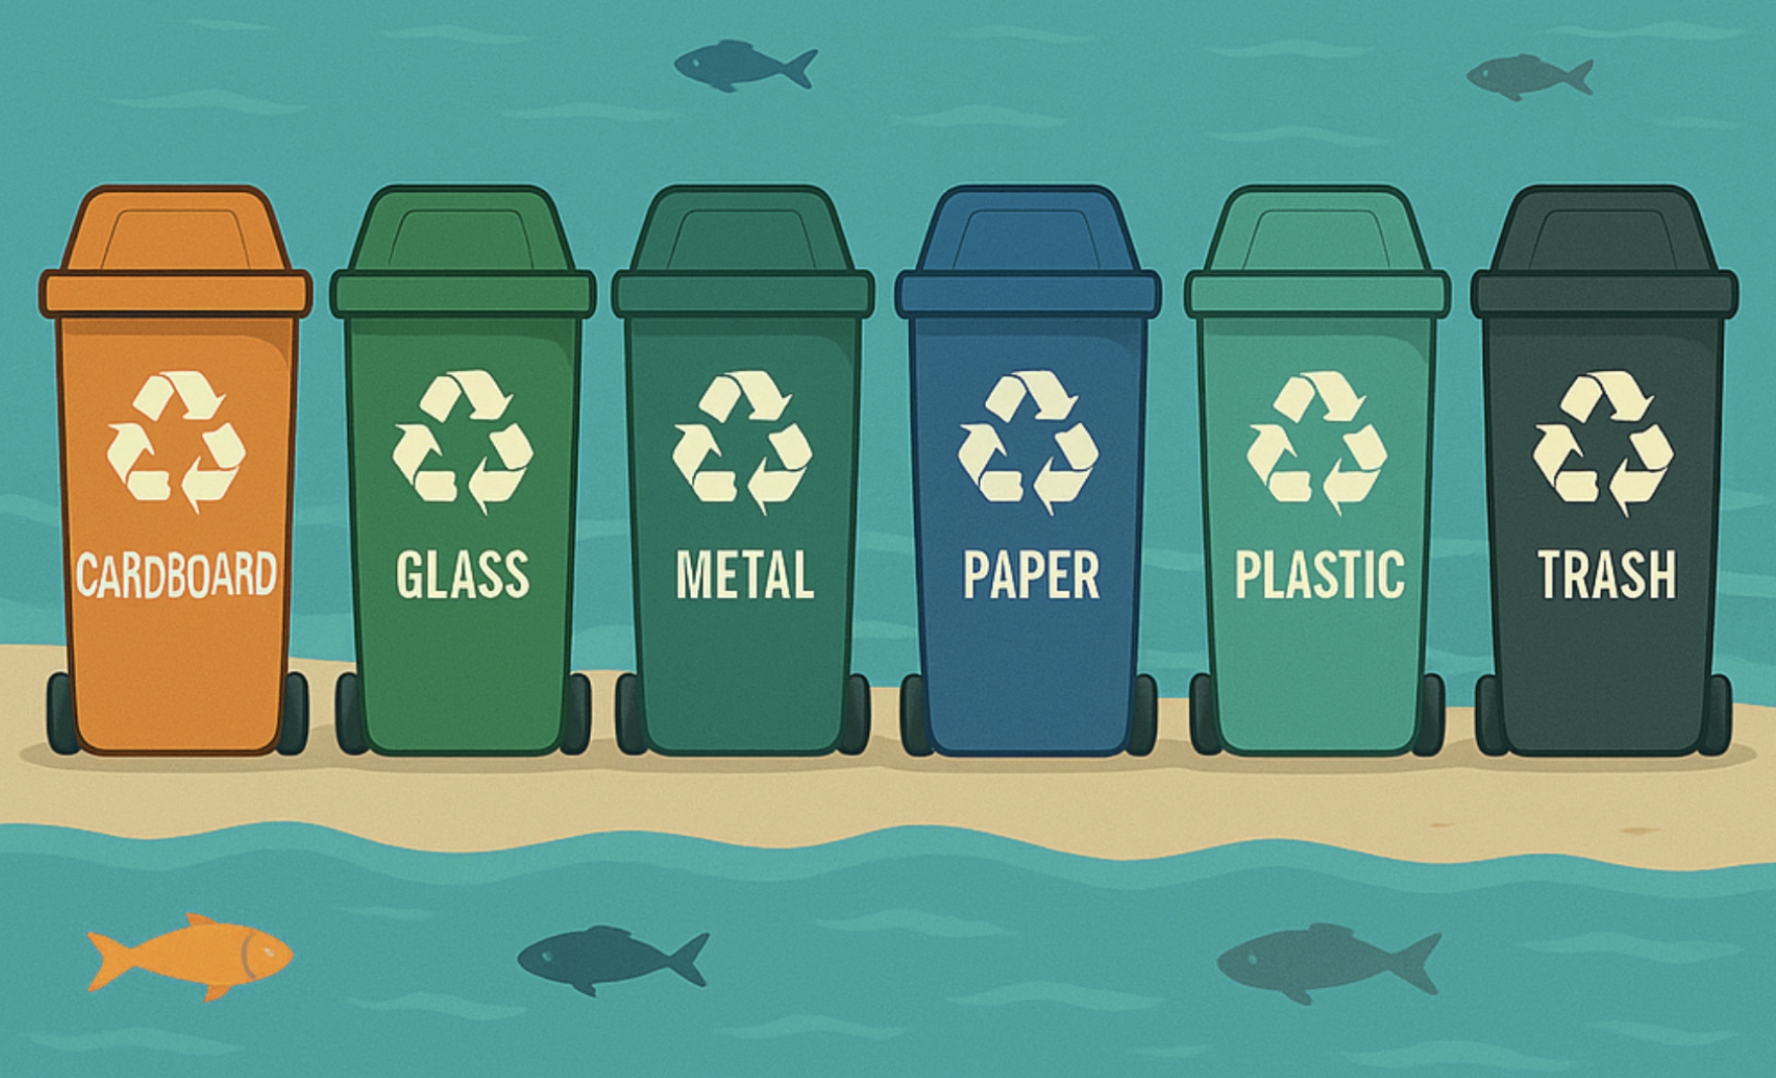

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, applications, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr

## 📌 1. Configuration & Setup
This section defines the core constants and hyperparameters to ensure your experiments are reproducible, organized, and easy to tune.

**Details:**
- **`DATA_DIR`** — Path to your dataset, structured with separate subfolders for each class.
- **`IMAGE_SIZE`** — The target resolution to resize all input images to a consistent square shape.
- **`BATCH_SIZE`** — Number of samples processed together during each training step.
- **`SEED`** — Random seed for consistent shuffling and reproducible splits.
- **`AUTOTUNE`** — Lets TensorFlow optimize dataset loading and performance automatically.
- **`EPOCHS`** — Maximum training epochs; training may stop earlier if early stopping is triggered.


In [ ]:
DATA_DIR = "Dataset"
IMAGE_SIZE = (124, 124)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 15  # EarlyStopping will likely stop earlier if no improvement in 3 epochs

## 📌 2. Data Loading & Splitting
This section loads the image data from disk using Keras utilities, with an organized and reproducible split:

**Key points:**
- **Stratified Split:** 80% for training; the remaining 20% is divided equally into validation and test sets.
- **`raw_val_ds`**: Used for monitoring validation loss and accuracy during training.
- **`raw_test_ds`**: Held back until final model evaluation.
- **Caching & Prefetching:** Speeds up data input pipelines by caching datasets in memory and prefetching batches.


In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
class_names = raw_train_ds.class_names  # e.g. ['plastic', 'glass', ...]
num_classes = len(class_names)

print(class_names)
print(num_classes)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [ ]:
raw_val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
# Divide the validation set evenly into validation & test
val_batches = tf.data.experimental.cardinality(raw_val_test_ds)
raw_val_ds = raw_val_test_ds.take(val_batches // 2)
raw_test_ds = raw_val_test_ds.skip(val_batches // 2)

In [ ]:
# Optimize I/O
train_ds = raw_train_ds.cache().prefetch(AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(AUTOTUNE)
test_ds_eval = raw_test_ds.cache().prefetch(AUTOTUNE)

## 📌 3. Class Weight Calculation
To mitigate the impact of any class imbalance, we compute per-class weights that penalize mistakes on minority classes more heavily.

**Key points:**
- Collect all labels from the training batches into one array.
- Use `sklearn`'s `compute_class_weight` with `balanced` mode to calculate appropriate weights.
- Map these weights to class names for clarity.
- Pass these weights to `model.fit()` to encourage balanced learning.

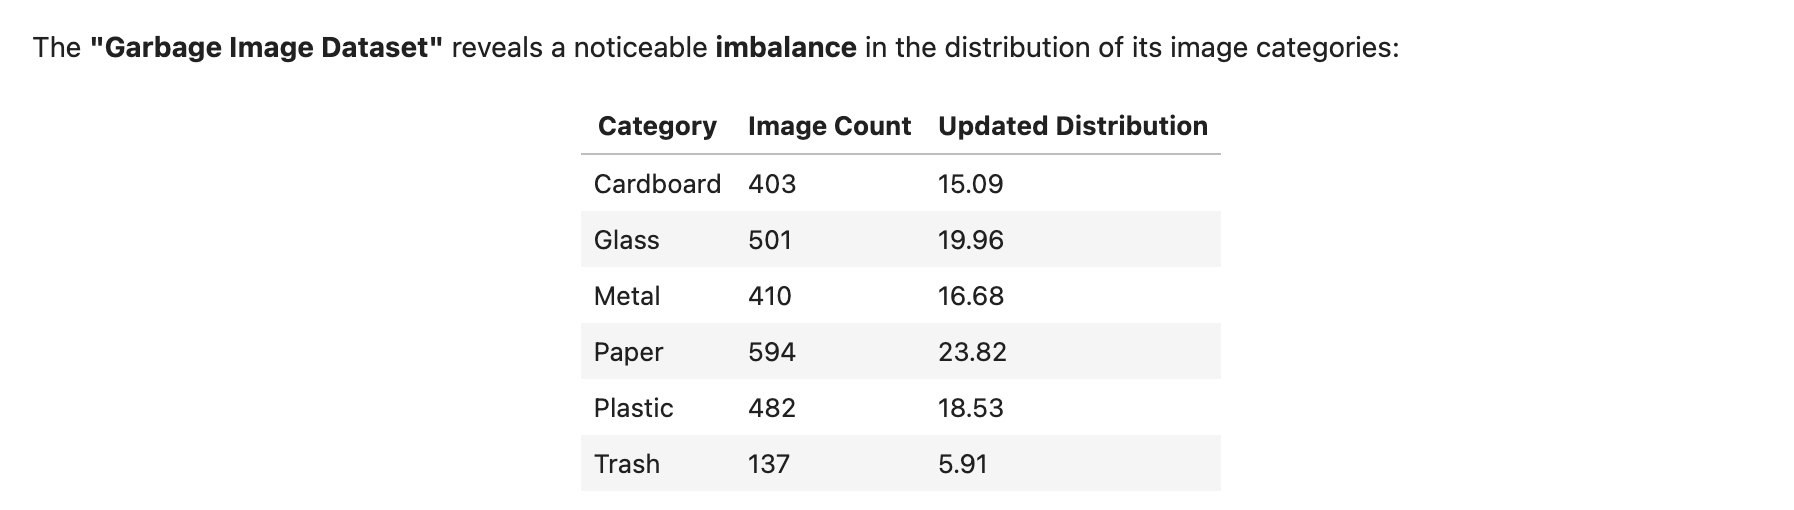


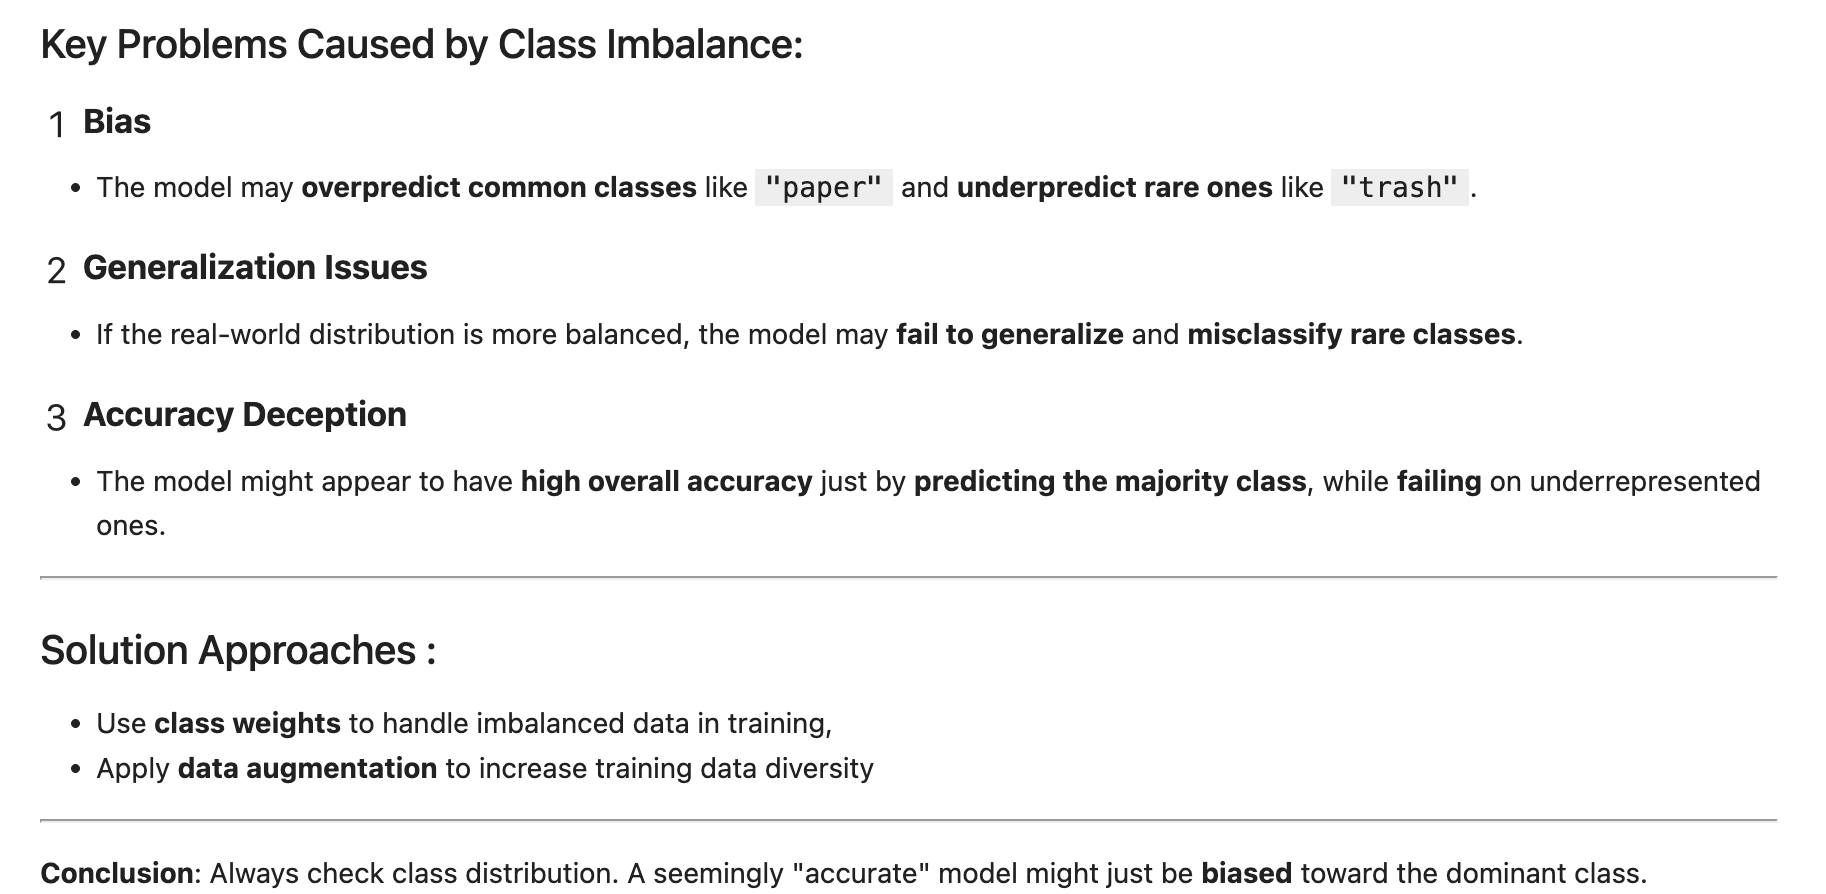

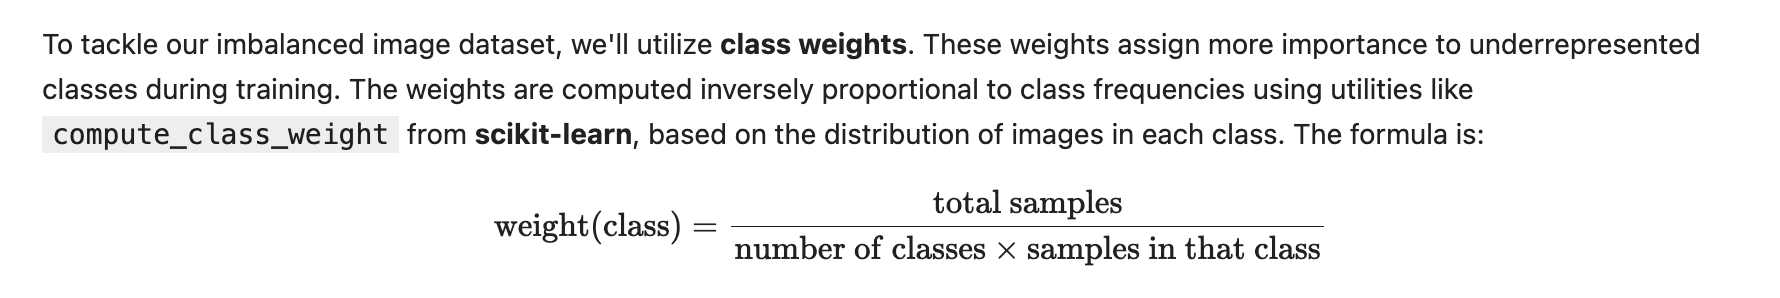

In [ ]:
# Gather all labels from the training set
all_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)

# Compute balanced class weights
weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=all_labels)
class_weights = dict(enumerate(weights))  # Numeric index to weight

# Map numeric indices to class names
named_class_weights = {class_names[i]: float(w) for i, w in class_weights.items()}

print("Class weight mapping:")
for cls, wt in named_class_weights.items():
    print(f"  {cls}: {wt:.3f}")

Class weight mapping:
  cardboard: 1.009
  glass: 0.845
  metal: 1.047
  paper: 0.715
  plastic: 0.858
  trash: 3.272


## 📌 4. Real-Time Data Augmentation

To help the model generalize better to real-world variations, we define an augmentation pipeline:
- Random horizontal flips simulate mirrored views.
- Random rotations introduce slight orientation changes.
- Random zooms help the model become robust to scale variations.
- Random contrast tweaks add lighting variation.

All transformations are applied **on-the-fly** during training, so no extra disk storage is needed.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(*IMAGE_SIZE,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 📌 5. Models Function

I have define a reusable function `build_model(name)` that:
- Loads a selected pretrained architecture (EfficientNetV2, MobileNetV2, ResNet50, etc.).
- Freezes the first half of its layers to keep pretrained features intact.
- Stacks our augmentation pipeline, global average pooling, dropout regularization, and a final softmax output layer.
- Compiles the model with Adam optimizer and sparse categorical cross-entropy (since labels are integer indices).


##Transfer Learning

Transfer Learning is a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task. It also allows us to build accurate models in a time-saving way by starting from patterns learned when solving a different problem. This approach is beneficial when there is limited data for the new task, as the pre-trained model already has learned features that can be adapted. Transfer learning can significantly improve models' performance and efficiency in domains like computer vision and natural language processing.



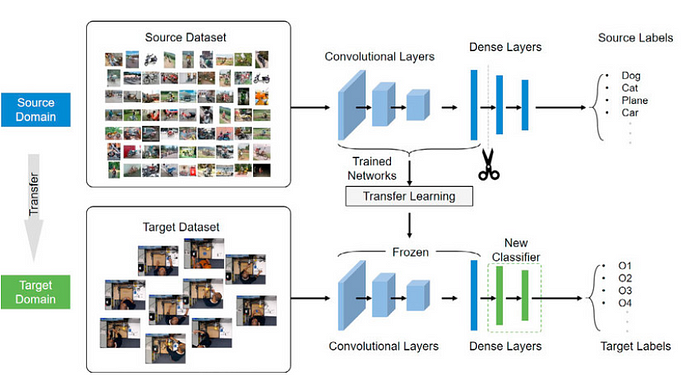

In [ ]:
def build_model(name):
    """
    Returns a compiled transfer-learning model based on the given architecture name.
    """
    base_map = {
        'V2S': applications.EfficientNetV2S,
        'V2M': applications.EfficientNetV2M,
        'V2B2': applications.EfficientNetV2B2,
        'V2L': applications.EfficientNetV2L,
        'EffiB0': applications.EfficientNetB0,
        'MobileNetV2': applications.MobileNetV2,
        'ResNet50': applications.ResNet50
    }
    Base = base_map[name]

    # Instantiate base model without its top classification layers
    base = Base(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE,3))
    total_layers = len(base.layers)
    freeze_count = total_layers // 2
    # Freeze the first half of layers
    for layer in base.layers[:freeze_count]:
        layer.trainable = False

    # Build new head for our 6-class problem
    inputs = layers.Input((*IMAGE_SIZE,3))
    x = data_augmentation(inputs)
    x = base(x, training=False)  # ensures BatchNorm layers run in inference mode
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(0.3, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name=name)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 📌 6. Training Loop & Parameter Summary

This section performs the end-to-end training for each selected architecture:

- Builds the model using `build_model`.
- Logs the number of trainable and non-trainable parameters for each network.
- Trains the model with class weights to address any imbalance.
- Uses early stopping with patience of 3 epochs based on validation loss.
- Saves the training history and final trained model for each architecture.


In [ ]:
model_names = ['V2S','V2M','V2B2','V2L','EffiB0','MobileNetV2','ResNet50']
histories = {}
param_counts = {}

for name in model_names:
    print(f"\n--- Training {name} ---")
    model = build_model(name)
    # Parameter breakdown
    param_counts[name] = {
        'trainable': model.count_params(),
        'non_trainable': int(np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]))
    }
    # Fit with class weights to handle imbalance
    early_stopper = callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True,
        verbose=1
    )
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=[early_stopper]
    )
    histories[name] = {'model': model, 'history': history}


--- Training V2S ---
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 262ms/step - accuracy: 0.3675 - loss: 1.5670 - val_accuracy: 0.7227 - val_loss: 0.8701
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.7770 - loss: 0.7027 - val_accuracy: 0.8359 - val_loss: 0.5452
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8795 - loss: 0.4153 - val_accuracy: 0.8633 - val_loss: 0.4240
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9231 - loss: 0.2604 - val_accuracy: 0.8828 - val_loss: 0.3892
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9538 - loss: 0.1792 - val_accuracy: 0.8945 - val_loss: 0.3414
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9667 - loss: 0.1135 - val_accuracy: 0.8945 - val_loss: 0.3336
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9837 - loss: 0.0673 - val_accuracy: 0.8906 - val_loss: 0.3429
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9916 - loss

/tmp/ipython-input-9-1587574800.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = Base(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE,3))


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.3283 - loss: 1.8868 - val_accuracy: 0.2031 - val_loss: 3.2508
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5808 - loss: 1.0818 - val_accuracy: 0.2031 - val_loss: 4.1437
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6550 - loss: 0.8959 - val_accuracy: 0.2070 - val_loss: 4.5760
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6718 - loss: 0.8366 - val_accuracy: 0.2188 - val_loss: 4.1487
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

--- Training ResNet50 ---
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.4283 - loss: 1.6138 - val_accuracy: 0.7461 - val_loss: 0.9252
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8296 - loss: 0.4806 - val_accuracy: 0.8242 - val_loss: 0.4661
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9170 - loss: 0.2451 - val_accuracy: 0.8633 - val_loss: 0.

## 📌 7. Validation Metrics Visualization

This section visualizes training progress for each architecture:

- Plots **validation accuracy** and **validation loss** over epochs.
- Uses a clean `ggplot` style with distinct colors for clarity.
- Displays accuracy with solid lines and loss with dashed lines.
- Legends are placed outside the plots to avoid clutter.


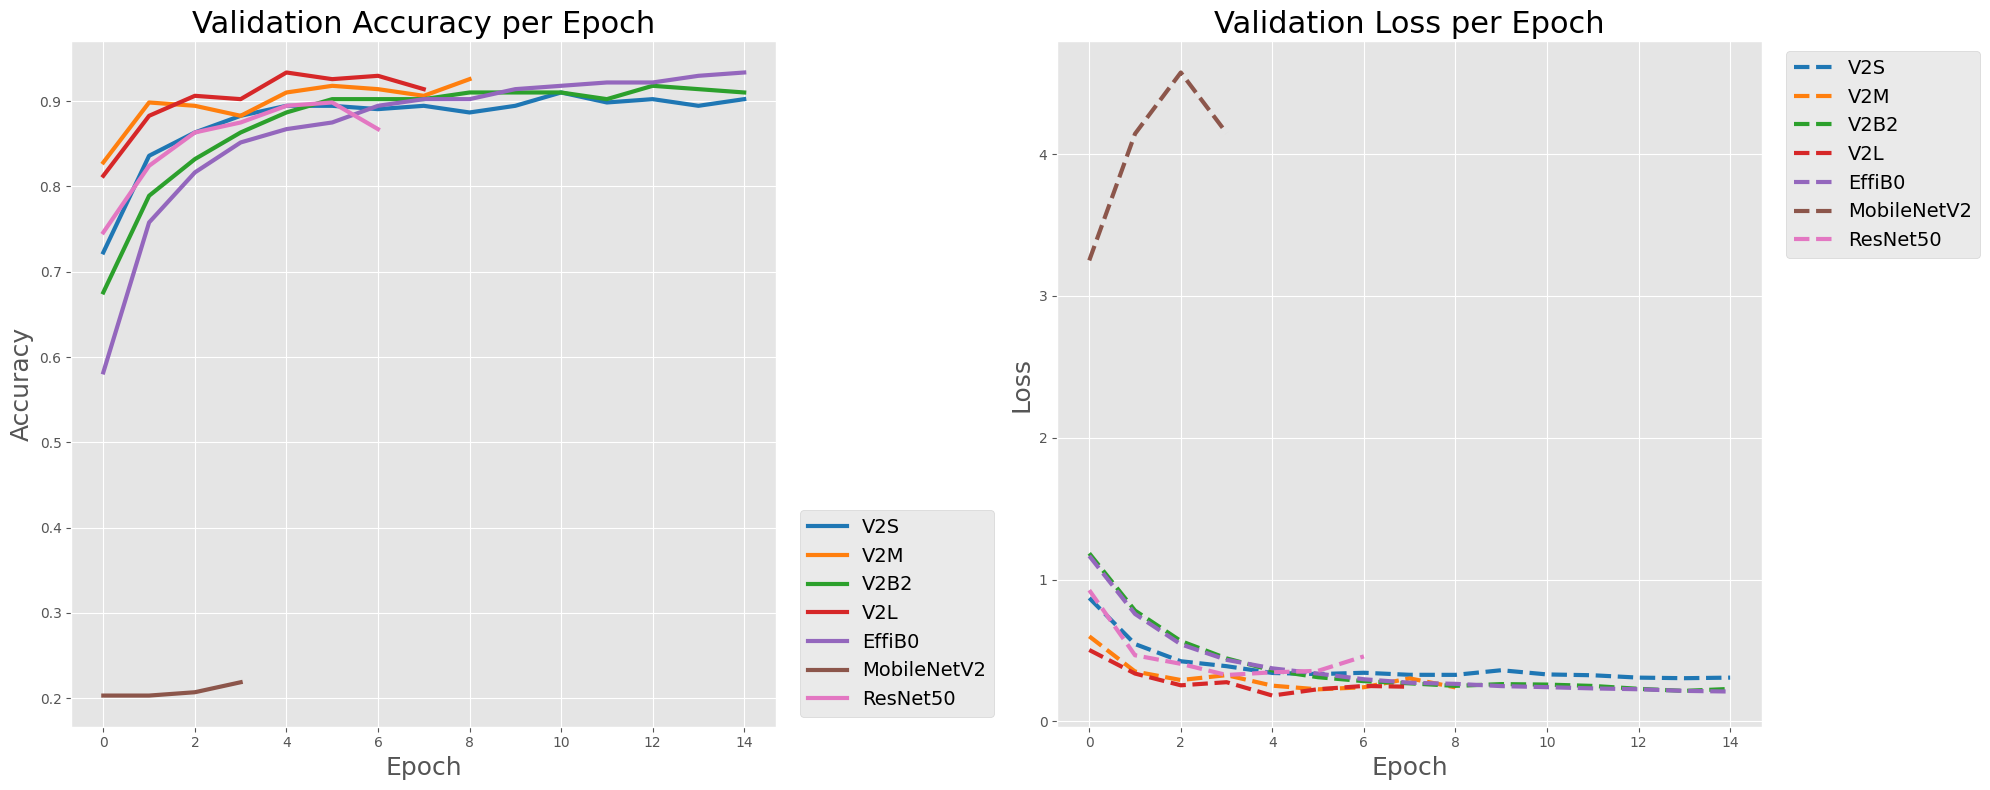

In [ ]:
# Use a built‑in style
plt.style.use('ggplot')
colors = plt.get_cmap('tab10').colors

# Create a very large canvas
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot each model’s curves with thick lines
for i, (name, info) in enumerate(histories.items()):
    axes[0].plot(info['history'].history['val_accuracy'],
                 label=name, color=colors[i], linewidth=3)
    axes[1].plot(info['history'].history['val_loss'],
                 '--', label=name, color=colors[i], linewidth=3)

# Set big titles and labels
axes[0].set_title('Validation Accuracy per Epoch', fontsize=22)
axes[0].set_xlabel('Epoch', fontsize=18)
axes[0].set_ylabel('Accuracy', fontsize=18)

axes[1].set_title('Validation Loss per Epoch', fontsize=22)
axes[1].set_xlabel('Epoch', fontsize=18)
axes[1].set_ylabel('Loss', fontsize=18)

# Place legends outside to keep plot area clear
axes[0].legend(fontsize=14, loc='lower left', bbox_to_anchor=(1.02, 0))
axes[1].legend(fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1))

# Enable grid and tighten layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()


## 📌 8. Parameter Count Comparison

This section visualizes the model complexity:

- A **grouped bar chart** compares **trainable** vs **non-trainable** parameters for each architecture.
- Highlights trade-offs between model size and potential performance.


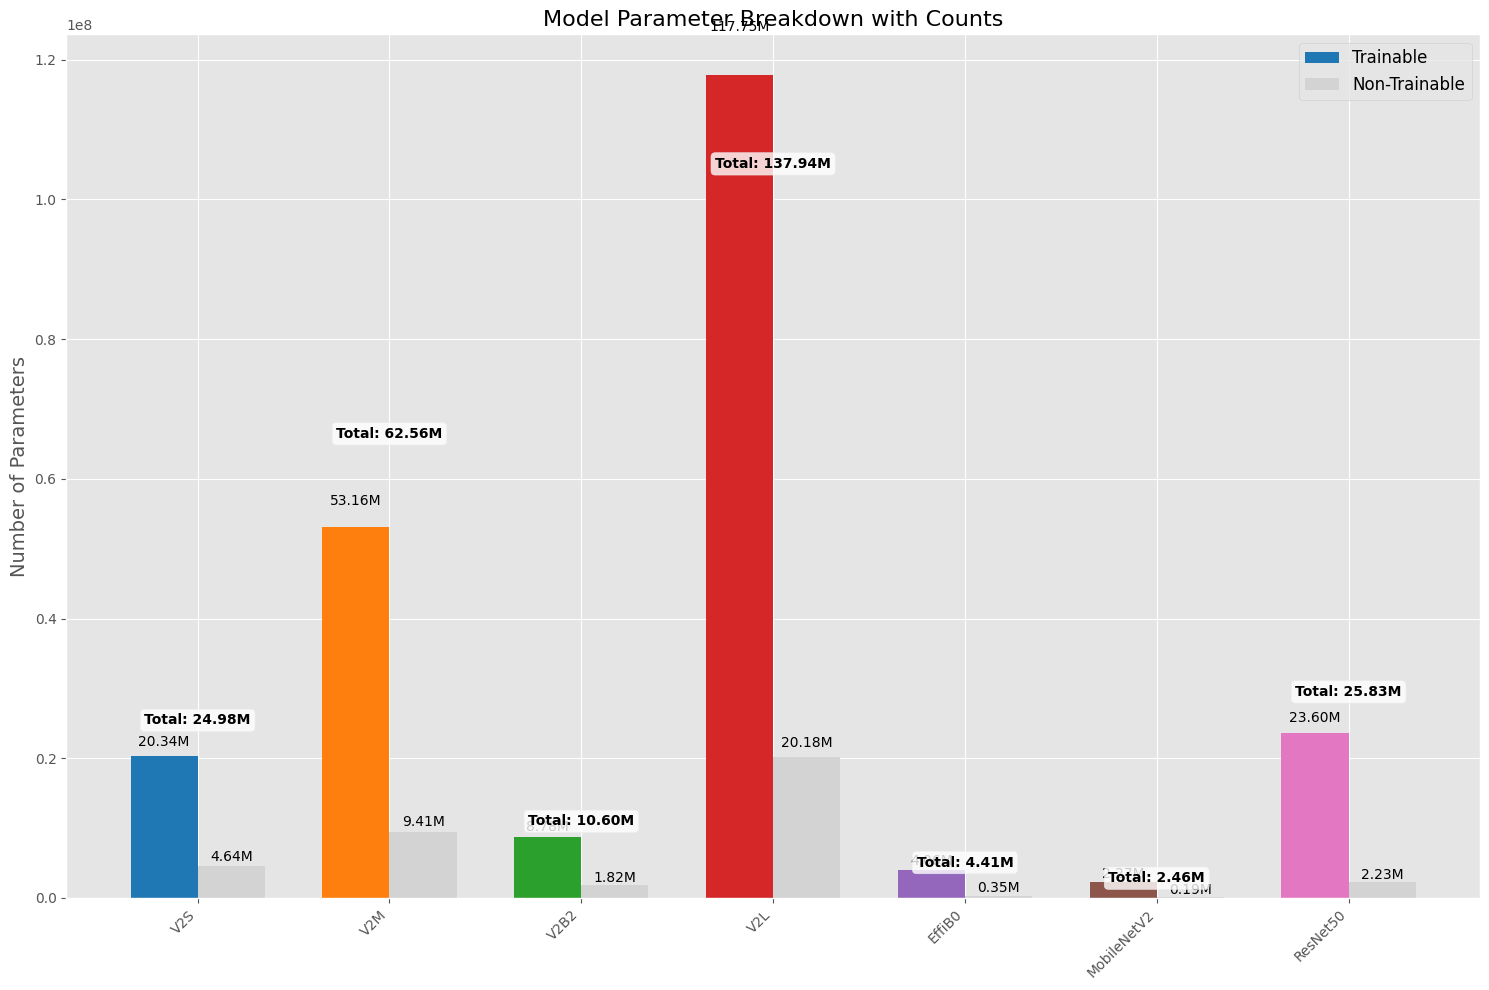

In [ ]:
names = list(param_counts.keys())
trainable = [param_counts[n]['trainable'] for n in names]
non_trainable = [param_counts[n]['non_trainable'] for n in names]
total = [t + nt for t, nt in zip(trainable, non_trainable)]
x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(15, 10))
train_bars = plt.bar(x - width/2, trainable, width, label='Trainable', color=colors)
nontrain_bars = plt.bar(x + width/2, non_trainable, width, label='Non-Trainable', color='lightgray')

# Get the current y-axis limits to ensure labels stay within bounds
current_ylim = plt.ylim()
y_max = current_ylim[1]

# Add labels with proper spacing and boundary checking
for i, (t, nt) in enumerate(zip(trainable, non_trainable)):
    # Individual parameter labels
    plt.text(x[i] - width/2, t * 1.05, f'{t/1e6:.2f}M', ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, nt * 1.05, f'{nt/1e6:.2f}M', ha='center', va='bottom', fontsize=10)

    # Total parameter label with safe positioning
    max_bar_height = max(t, nt)
    # Position total label with adequate spacing but ensure it stays within graph bounds
    total_label_y = min(max_bar_height * 1.25, y_max * 0.85)
    plt.text(x[i], total_label_y, f'Total: {total[i]/1e6:.2f}M', ha='center', va='center',
             fontsize=10, weight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xticks(x, names, rotation=45, ha='right')
plt.ylabel('Number of Parameters', fontsize=14)
plt.title('Model Parameter Breakdown with Counts', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


---

## 🔬 Final Test Evaluation

This section performs the final evaluation on the **unseen test set**, providing an honest measure of real-world performance.

- **Evaluate each trained model** on the held-out test dataset.
- **Compare test accuracies** across all architectures.
- **Identify the best-performing model** for detailed reporting.
- **Generate a classification report** and **confusion matrix** to analyze per-class performance and misclassifications.



In [ ]:
test_results = {}
for name, info in histories.items():
    loss, acc = info['model'].evaluate(test_ds_eval, verbose=0)
    test_results[name] = acc
    print(f"{name} Test Accuracy: {acc:.4f}")

V2S Test Accuracy: 0.8916
V2M Test Accuracy: 0.9157
V2B2 Test Accuracy: 0.8876
V2L Test Accuracy: 0.9157
EffiB0 Test Accuracy: 0.9197
MobileNetV2 Test Accuracy: 0.1968
ResNet50 Test Accuracy: 0.8554


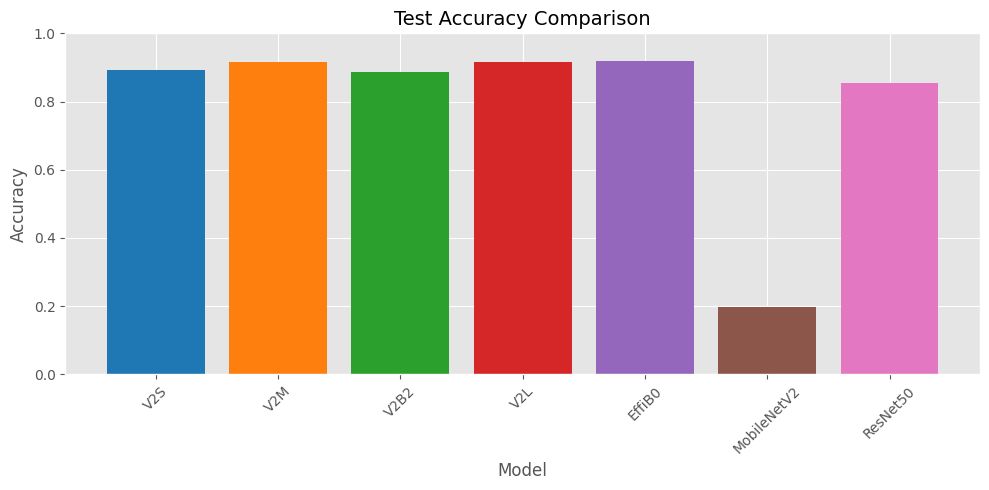

In [ ]:
# Bar chart for test accuracies
plt.figure(figsize=(10,5))
plt.bar(test_results.keys(), test_results.values(), color=colors)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

# Detailed metrics for the top-performing model
best_model_name = max(test_results, key=test_results.get)
best_model = histories[best_model_name]['model']
print(f"\nBest Model: {best_model_name} with Test Accuracy = {test_results[best_model_name]:.4f}\n")


Best Model: EffiB0 with Test Accuracy = 0.9197



In [ ]:
best_model.summary()

Model: "EffiB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,470,407 (43.76 MB)

 Trainable params: 3,706,574 (14.14 MB)

 Non-trainable params: 350,683 (1.34 MB)

 Optimizer params: 7,413,150 (28.28 MB)

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)
y_pred = np.argmax(best_model.predict(test_ds_eval), axis=1)

print("Classification Report for Best Model:")
print(classification_report(y_true, y_pred, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step
Classification Report for Best Model:
              precision    recall  f1-score   support

   cardboard       0.85      0.88      0.87        33
       glass       0.98      0.96      0.97        57
       metal       0.88      0.93      0.90        45
       paper       0.90      0.92      0.91        59
     plastic       0.95      0.90      0.92        40
       trash       1.00      0.87      0.93        15

    accuracy                           0.92       249
   macro avg       0.93      0.91      0.92       249
weighted avg       0.92      0.92      0.92       249



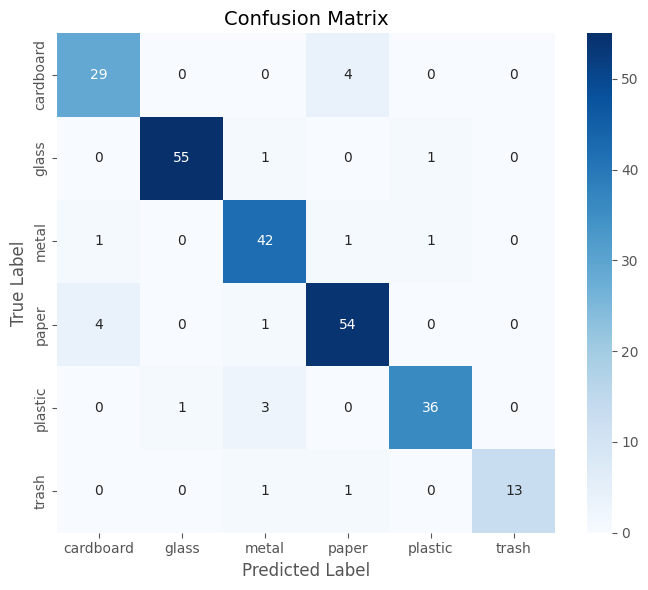

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns = __import__('seaborn')  # delay import for faster startup
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


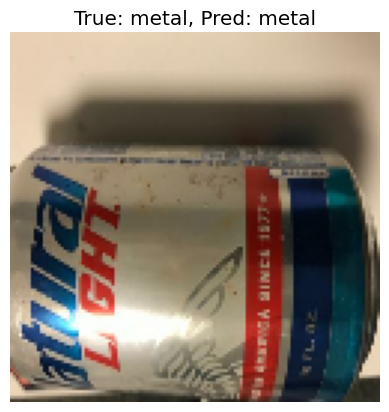

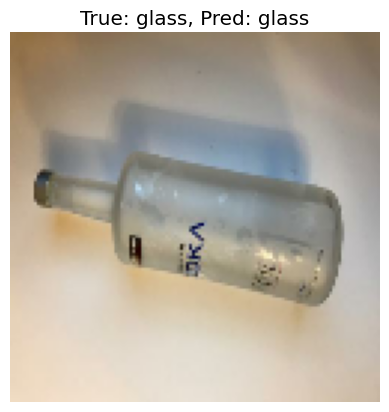

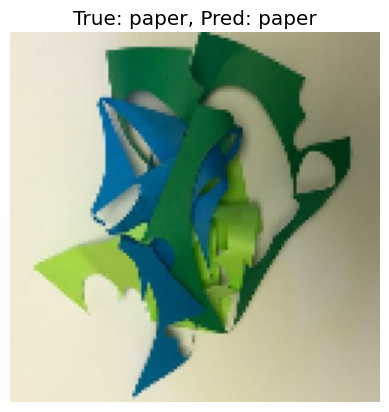

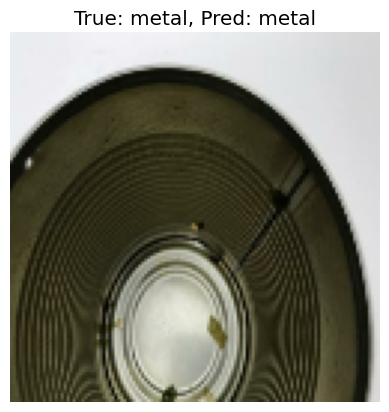

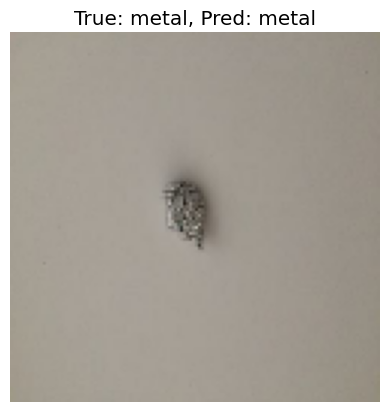

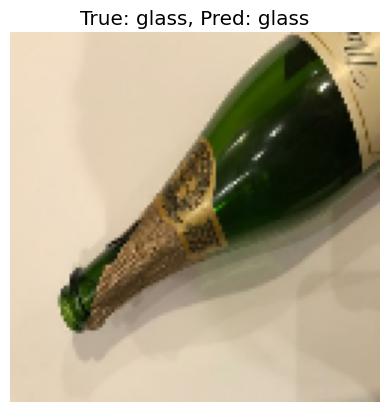

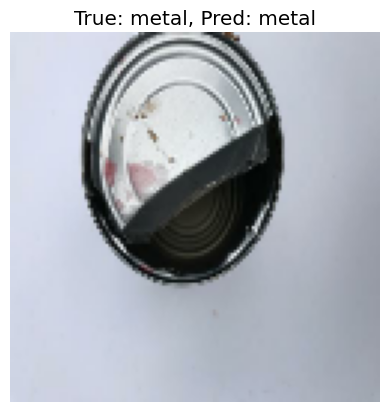

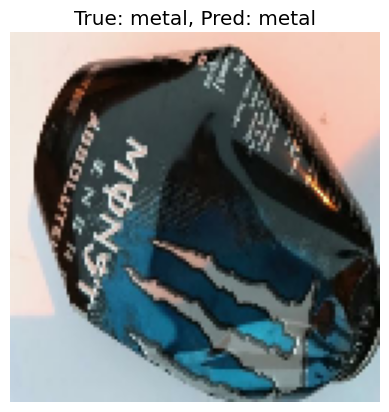

In [ ]:
class_names = raw_train_ds.class_names

# ✅ Visualize predictions on test samples
for images, labels in test_ds_eval.take(1):
    predictions = best_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


## 📦 Save & Deploy the Best Model with Gradio 🚀

This section finalizes the project by making the best-trained model ready for practical use.

- **Save the best model** in Keras `.keras` format for future deployment.
- **Define an easy-to-use prediction function** that resizes any uploaded image and returns class probabilities.
- **Deploy an interactive Gradio web app** that lets users upload images and see the top predicted categories.


In [ ]:
best_model.save(f"best_{best_model_name}.keras")

def classify_image(img):
    """Resizes input and returns top 3 class probabilities."""
    img = tf.image.resize(img, IMAGE_SIZE)[None, ...]
    preds = best_model.predict(img, verbose=0)[0]
    return {class_names[i]: float(preds[i]) for i in np.argsort(preds)[::-1][:3]}

# Launch the demo interface

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    description="Classify images into cardboard, glass, metal, paper, plastic, or trash.",
    allow_flagging='never'
)

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a548a64976d1b0166a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## ✅ Conclusion

In this project, I have designed and implemented a complete **garbage classification pipeline** using cutting-edge **transfer learning**. I trained and compared seven powerful CNN architectures — **EfficientNetV2S**, **EfficientNetV2M**, **EfficientNetV2B2**, **EfficientNetV2L**, **EfficientNetB0**, **MobileNetV2**, and **ResNet50** — to automatically classify six common waste types: **cardboard**, **glass**, **metal**, **paper**, **plastic**, and **trash**.

Through careful **data preprocessing**, **augmentation**, and **class imbalance handling**, I ensured robust training conditions. The **parameter breakdown** highlighted the trade-off between model size and performance. Notably, **EfficientNetB0** achieved the best result, delivering a strong **91.97% test accuracy** with minimal parameter overhead — proving that well-optimized, compact models can outperform larger ones in real-world tasks.

To make this solution practically useful, I deployed the best-performing model using **Gradio** and hosted it on **Hugging Face**, providing an accessible, user-friendly interface for real-time trash classification.


